# 1. Data Cleaning

In [1]:
from __future__ import annotations

# Standard library
import math
from typing import Any, Dict, Optional, Tuple

# Scientific computing
import numpy as np
import pandas as pd
from scipy.signal import periodogram
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Visualization
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

In [2]:
DATA_PATH = "../data/Motor_Vehicle_Collisions_-_Crashes_20260104.csv"

# Relevant columns for this project
RAW_COLUMNS = [
    "CRASH DATE",
    "CRASH TIME",
    "BOROUGH",
    "ZIP CODE",
    "LATITUDE",
    "LONGITUDE",
    "LOCATION",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
]


In [3]:
df_collisions = pd.read_csv(
    DATA_PATH,
    usecols=RAW_COLUMNS,
    dtype={
        "ZIP CODE": "string",
        "BOROUGH": "string",
    },
    low_memory=False,
)

print("Raw shape:", df_collisions.shape)
display(df_collisions.head())

Raw shape: (2232154, 9)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
0,09/11/2021,2:39,<NA>,<NA>,NaN,NaN,NaN,0,0
1,03/26/2022,11:45,<NA>,<NA>,NaN,NaN,NaN,0,0
2,11/01/2023,1:29,BROOKLYN,11230,"40,62179","-73,970024","(40.62179, -73.970024)",0,0
3,06/29/2022,6:55,<NA>,<NA>,NaN,NaN,NaN,0,0
4,09/21/2022,13:21,<NA>,<NA>,NaN,NaN,NaN,0,0


In [4]:
print("Number of rows:", df_collisions.shape[0])
print("Number of columns:", df_collisions.shape[1])

print("\nColumns:")
print(df_collisions.columns.tolist())

print("\nMissing values per column:")
display(df_collisions.isna().sum())

Number of rows: 2232154
Number of columns: 9

Columns:
['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']

Missing values per column:


CRASH DATE                        0
CRASH TIME                        0
BOROUGH                      682576
ZIP CODE                     682855
LATITUDE                     240475
LONGITUDE                    240475
LOCATION                     240475
NUMBER OF CYCLIST INJURED         0
NUMBER OF CYCLIST KILLED          0
dtype: int64

In [5]:
# Only keep collisions where at least one cyclist was injured
mask_cyclist_injured = df_collisions["NUMBER OF CYCLIST INJURED"] > 0
df_collisions = df_collisions.loc[mask_cyclist_injured].copy()

print("After filtering to cyclist injuries:")
print("Shape:", df_collisions.shape)
display(df_collisions.head())

After filtering to cyclist injuries:
Shape: (64535, 9)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
33,12/14/2021,12:54,BROOKLYN,11217,"40,687534","-73,9775","(40.687534, -73.9775)",1,0
37,12/14/2021,16:25,<NA>,<NA>,"40,784615","-73,953964","(40.784615, -73.953964)",1,0
62,04/24/2022,15:35,MANHATTAN,10019,"40,767242","-73,986206","(40.767242, -73.986206)",1,0
77,12/09/2021,20:20,BROOKLYN,11223,"40,59207","-73,96299","(40.59207, -73.96299)",1,0
83,12/09/2021,23:15,BROOKLYN,11218,"40,640835","-73,98967","(40.640835, -73.98967)",1,0


In [6]:
# Convert LATITUDE / LONGITUDE from "40,62179" style to float
for col in ["LATITUDE", "LONGITUDE"]:
    df_collisions[col] = pd.to_numeric(
        df_collisions[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip(),
        errors="coerce",           # invalid -> NaN
    )

# Combine date & time into a single datetime
df_collisions["CRASH_DATETIME"] = pd.to_datetime(
    df_collisions["CRASH DATE"] + " " + df_collisions["CRASH TIME"],
    format="%m/%d/%Y %H:%M",
    errors="raise",               # crash early if something is weird
)

# We don't need the separate date / time columns anymore
df_collisions.drop(columns=["CRASH DATE", "CRASH TIME"], inplace=True)

print("Dtypes after conversion:")
print(df_collisions.dtypes)

Dtypes after conversion:
BOROUGH                      string[python]
ZIP CODE                     string[python]
LATITUDE                            float64
LONGITUDE                           float64
LOCATION                             object
NUMBER OF CYCLIST INJURED             int64
NUMBER OF CYCLIST KILLED              int64
CRASH_DATETIME               datetime64[ns]
dtype: object


In [7]:
# Rough bounding box around NYC
MIN_LAT, MAX_LAT = 40.4, 41.0
MIN_LON, MAX_LON = -74.3, -73.6

# Identify out-of-bounds coordinates
bad_mask = (
    (df_collisions["LATITUDE"] < MIN_LAT) |
    (df_collisions["LATITUDE"] > MAX_LAT) |
    (df_collisions["LONGITUDE"] < MIN_LON) |
    (df_collisions["LONGITUDE"] > MAX_LON)
)

# Look at problematic coordinates (including LOCATION for sanity check)
bad_coord_counts = (
    df_collisions.loc[bad_mask, ["LATITUDE", "LONGITUDE", "LOCATION"]]
    .value_counts()
    .sort_index()
)
print("Out-of-bounds coordinate combinations:")
display(bad_coord_counts)

# Treat (0,0) as missing coordinates
zero_mask = (df_collisions["LATITUDE"] == 0) & (df_collisions["LONGITUDE"] == 0)
df_collisions.loc[zero_mask, ["LATITUDE", "LONGITUDE", "LOCATION"]] = np.nan

# Recompute bad mask and drop the truly bad coordinates
bad_mask = (
    (df_collisions["LATITUDE"] < MIN_LAT) |
    (df_collisions["LATITUDE"] > MAX_LAT) |
    (df_collisions["LONGITUDE"] < MIN_LON) |
    (df_collisions["LONGITUDE"] > MAX_LON)
)
df_collisions = df_collisions.loc[~bad_mask].copy()

print("Shape after dropping out-of-bounds coords:", df_collisions.shape)

Out-of-bounds coordinate combinations:


LATITUDE  LONGITUDE  LOCATION      
0.0       0.0            (0.0, 0.0)    314
                     (0.0, 0.0)         62
Name: count, dtype: int64

Shape after dropping out-of-bounds coords: (64535, 8)


In [8]:
missing_count = df_collisions.isna().sum()
missing_percent = (missing_count / len(df_collisions)) * 100

missing_df = pd.DataFrame(
    {
        "missing_count": missing_count,
        "total_rows": len(df_collisions),
        "missing_percent": missing_percent.round(2),
    }
)

print("Missingness summary:")
display(missing_df)

# Check if LAT/LON/LOCATION always go missing together
lat_missing = df_collisions["LATITUDE"].isna()
lon_missing = df_collisions["LONGITUDE"].isna()
loc_missing = df_collisions["LOCATION"].isna()

print("All three missing (LAT, LON, LOCATION):", (lat_missing & lon_missing & loc_missing).sum())
print("LAT/LON missing but LOCATION present:", ((lat_missing | lon_missing) & ~loc_missing).sum())

# Location doesnt give us extra info so we can drop it
df_collisions.drop(columns=["LOCATION"], inplace=True)

Missingness summary:


,missing_count,total_rows,missing_percent
BOROUGH,13595,64535,21.07
ZIP CODE,13597,64535,21.07
LATITUDE,4647,64535,7.20
LONGITUDE,4647,64535,7.20
LOCATION,4647,64535,7.20
NUMBER OF CYCLIST INJURED,0,64535,0.00
NUMBER OF CYCLIST KILLED,0,64535,0.00
CRASH_DATETIME,0,64535,0.00


All three missing (LAT, LON, LOCATION): 4647
LAT/LON missing but LOCATION present: 0


In [9]:
# Keep only the features we actually need for the modeling phase
final_columns = [
    "LATITUDE",
    "LONGITUDE",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
    "CRASH_DATETIME",
]

df_collisions = df_collisions[final_columns].copy()

print("Final cleaned dataframe shape:", df_collisions.shape)
display(df_collisions.head())

Final cleaned dataframe shape: (64535, 5)


,LATITUDE,LONGITUDE,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,CRASH_DATETIME
33,40.687534,-73.977500,1,0,2021-12-14 12:54:00
37,40.784615,-73.953964,1,0,2021-12-14 16:25:00
62,40.767242,-73.986206,1,0,2022-04-24 15:35:00
77,40.592070,-73.962990,1,0,2021-12-09 20:20:00
83,40.640835,-73.989670,1,0,2021-12-09 23:15:00


- I have decided against an imputation of lat/long values through Neighborhood/Borough because it wouldnt help us when modelling daily accident (its independent of location and for the MoG it would probably make the resulting distribution worse

# 2. Exploration

In [10]:
def compute_date_range(df: pd.DataFrame) -> Tuple[pd.Timestamp, pd.Timestamp]:
    """Return the earliest and latest CRASH_DATETIME in the dataframe."""
    earliest = df["CRASH_DATETIME"].min()
    latest = df["CRASH_DATETIME"].max()
    return earliest, latest


def compute_avg_counts(df: pd.DataFrame) -> Tuple[float, float]:
    """Return average accidents per day and per hour."""
    
    daily_counts = (
        df.set_index("CRASH_DATETIME")
          .resample("D")
          .size()
    )
    
    hourly_counts = (
        df.set_index("CRASH_DATETIME")
          .resample("h")  # lowercase to avoid warning
          .size()
    )

    return float(daily_counts.mean()), float(hourly_counts.mean())

In [11]:
def plot_monthly_counts(df: pd.DataFrame) -> None:
    """Plot total collisions per month."""
    
    monthly_counts = (
        df.set_index("CRASH_DATETIME")
          .resample("ME")  # month end
          .size()
    )

    plt.figure(figsize=(12, 5))
    monthly_counts.plot()
    plt.title("Total Motor Vehicle Collisions per Month")
    plt.xlabel("Date")
    plt.ylabel("Number of Collisions")
    plt.show()



def plot_yearly_counts(df: pd.DataFrame) -> None:
    """Plot total collisions per year."""
    
    yearly_counts = (
        df.set_index("CRASH_DATETIME")
          .resample("YE")  # year end
          .size()
    )

    yearly_counts.index = yearly_counts.index.year

    plt.figure(figsize=(10, 5))
    yearly_counts.plot(kind="bar")
    plt.title("Total Motor Vehicle Collisions per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Collisions")
    plt.show()



def plot_weekday_counts(df: pd.DataFrame) -> None:
    """Plot crashes by day of week."""
    
    weekday_counts = (
        df["CRASH_DATETIME"]
        .dt.dayofweek
        .value_counts()
        .sort_index()
    )

    weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    plt.figure(figsize=(8, 4))
    weekday_counts.plot(kind="bar")
    plt.xticks(range(7), weekday_labels, rotation=0)
    plt.title("Total Crashes by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Number of Crashes")
    plt.show()



def plot_hourly_counts(df: pd.DataFrame) -> None:
    """Plot crashes by hour of day."""

    hour_counts = (
        df["CRASH_DATETIME"]
        .dt.hour
        .value_counts()
        .sort_index()
    )

    plt.figure(figsize=(10, 4))
    hour_counts.plot(kind="bar")
    plt.title("Total Crashes by Hour of Day")
    plt.xlabel("Hour (0–23)")
    plt.ylabel("Number of Crashes")
    plt.show()



def plot_month_counts(df: pd.DataFrame) -> None:
    """Plot crashes by month of year."""

    month_counts = (
        df["CRASH_DATETIME"]
        .dt.month
        .value_counts()
        .sort_index()
    )

    plt.figure(figsize=(10, 4))
    month_counts.plot(kind="bar")
    plt.title("Total Crashes by Month of Year")
    plt.xlabel("Month (1–12)")
    plt.ylabel("Number of Crashes")
    plt.show()

def plot_daily_count_distribution(df: pd.DataFrame) -> None:
    """
    Plot the frequency distribution of daily accident counts.
    X-axis = accidents per day
    Y-axis = number of days with that count
    """

    # Create daily counts
    daily_counts = (
        df.set_index("CRASH_DATETIME")
          .resample("D")
          .size()
    )

    # Count occurrences of each accident count value
    value_counts = daily_counts.value_counts().sort_index()

    plt.figure(figsize=(12, 5))
    value_counts.plot(kind="bar")

    plt.title("Distribution of Daily Accident Counts")
    plt.xlabel("Accidents per Day")
    plt.ylabel("Number of Days")
    plt.tight_layout()
    plt.show()

In [12]:
earliest, latest = compute_date_range(df_collisions)

print(f"Earliest crash: {earliest}")
print(f"Latest crash:   {latest}")

avg_day, avg_hour = compute_avg_counts(df_collisions)

print(f"Average crashes per day:  {avg_day:.3f}")
print(f"Average crashes per hour: {avg_hour:.3f}")

Earliest crash: 2012-07-01 02:30:00
Latest crash:   2025-12-29 23:27:00
Average crashes per day:  13.090
Average crashes per hour: 0.545


In [13]:
earliest = df_collisions["CRASH_DATETIME"].min()
latest   = df_collisions["CRASH_DATETIME"].max()

print("Earliest crash:", earliest)
print("Latest crash:", latest)

Earliest crash: 2012-07-01 02:30:00
Latest crash: 2025-12-29 23:27:00


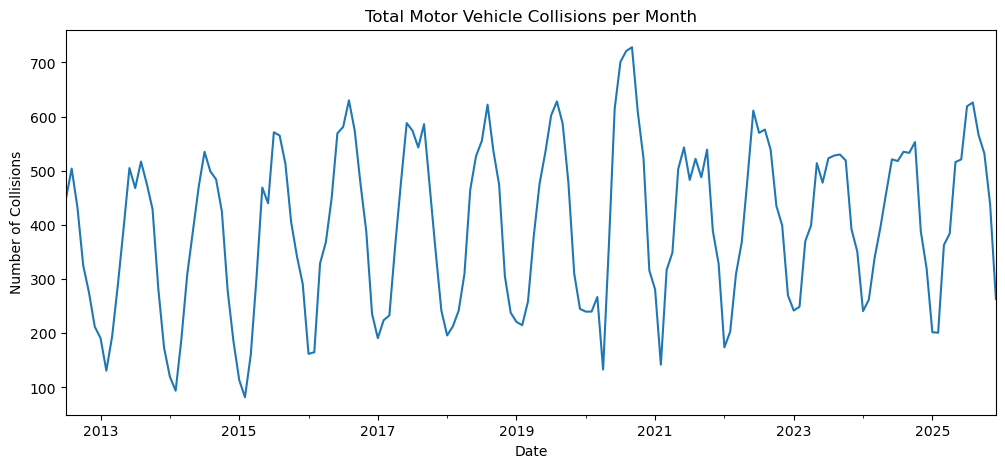

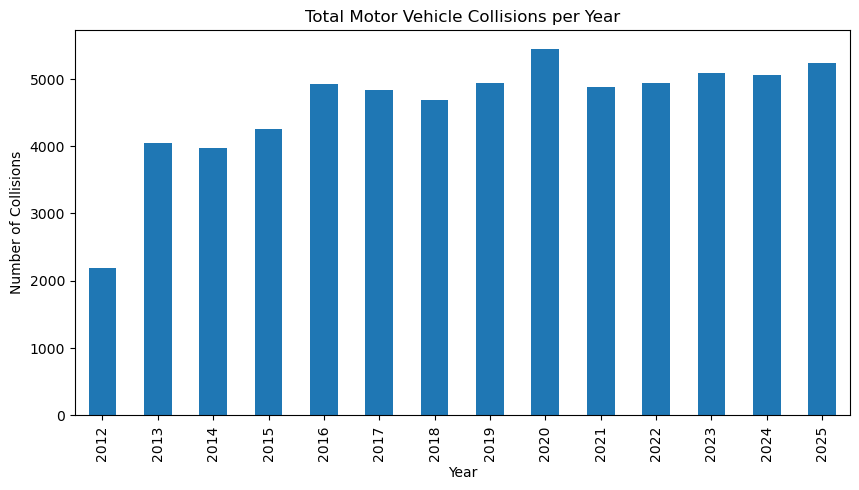

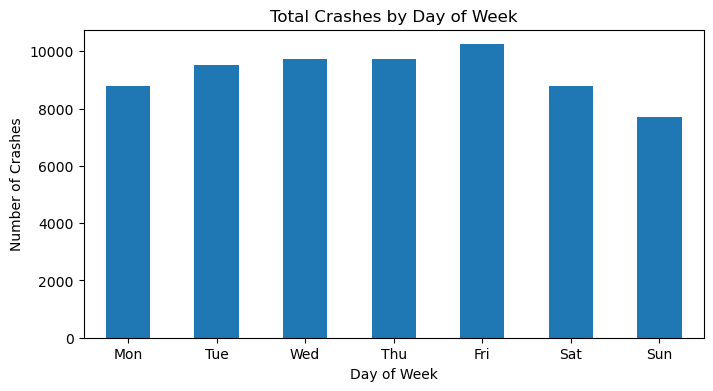

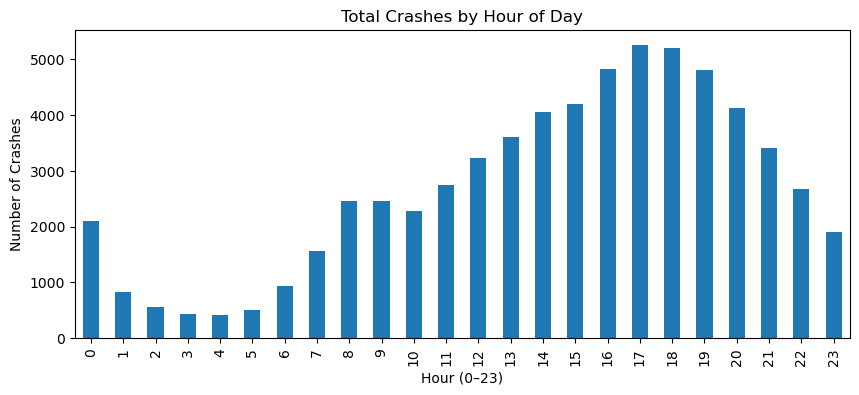

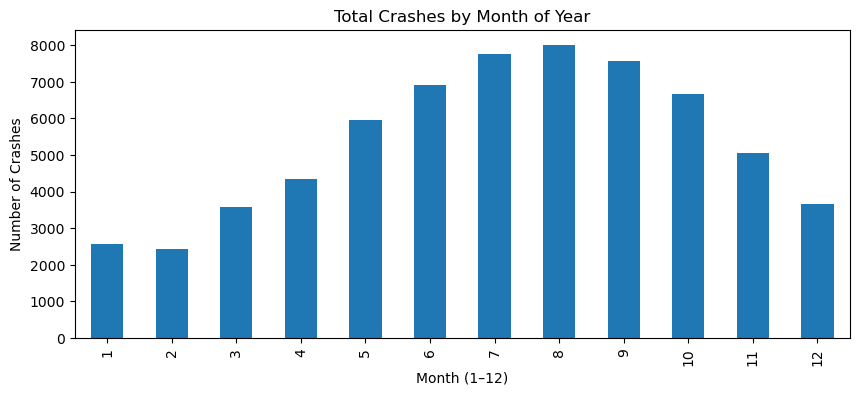

In [14]:
plot_monthly_counts(df_collisions)
plot_yearly_counts(df_collisions)

plot_weekday_counts(df_collisions)
plot_hourly_counts(df_collisions)
plot_month_counts(df_collisions)

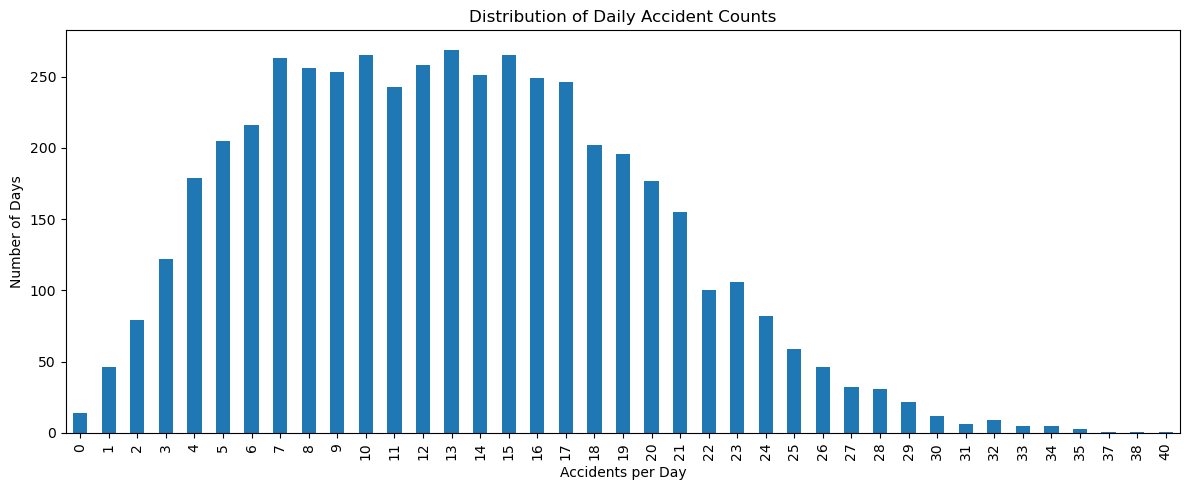

In [15]:
plot_daily_count_distribution(df_collisions)

- uni modal with a slight skew, no need to do target transformation for Linear Regression/XGBoost/Random Forest, they should be able to handle that

# 3. Time series feature selection/engineering

- time series = trend + seasonality + cyclic + nois
- since the accident data by the NPYPD is updated daily (https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data) we can use running averages/lags freely when analyzing daily accidents

In [16]:
sns.set_theme(style="whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = "retina"

# --- create daily counts dataframe ---
df_daily = (
    df_collisions
        .set_index("CRASH_DATETIME")
        .resample("D")
        .size()
        .to_frame(name="accident_count")
)
df_daily.index.name = "Day"

# use PeriodIndex (daily)
df_daily = df_daily.to_period("D")

# time index for trend
df_daily["Time"] = np.arange(len(df_daily.index), dtype="int32")

df_daily.head()

,accident_count,Time
Day,,
2012-07-01,9,0
2012-07-02,27,1
2012-07-03,16,2
2012-07-04,9,3
2012-07-05,14,4


In [17]:
def time_series_train_test_split(
    X: pd.DataFrame,
    y: pd.Series,
    test_horizon: int = 365,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split features and target into train/test, preserving time order.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix indexed by time.
    y : pd.Series
        Target series indexed by time (same index as X).
    test_horizon : int, default 365
        Number of final observations to keep as test set.
    """
    if len(X) != len(y):
        raise ValueError("X and y must have the same length.")

    if test_horizon <= 0 or test_horizon >= len(X):
        raise ValueError("test_horizon must be between 1 and len(X)-1.")
    
    split_idx = len(X) - test_horizon

    X_train = X.iloc[:split_idx].copy()
    X_test  = X.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test  = y.iloc[split_idx:].copy()

    return X_train, X_test, y_train, y_test

## A) Trend

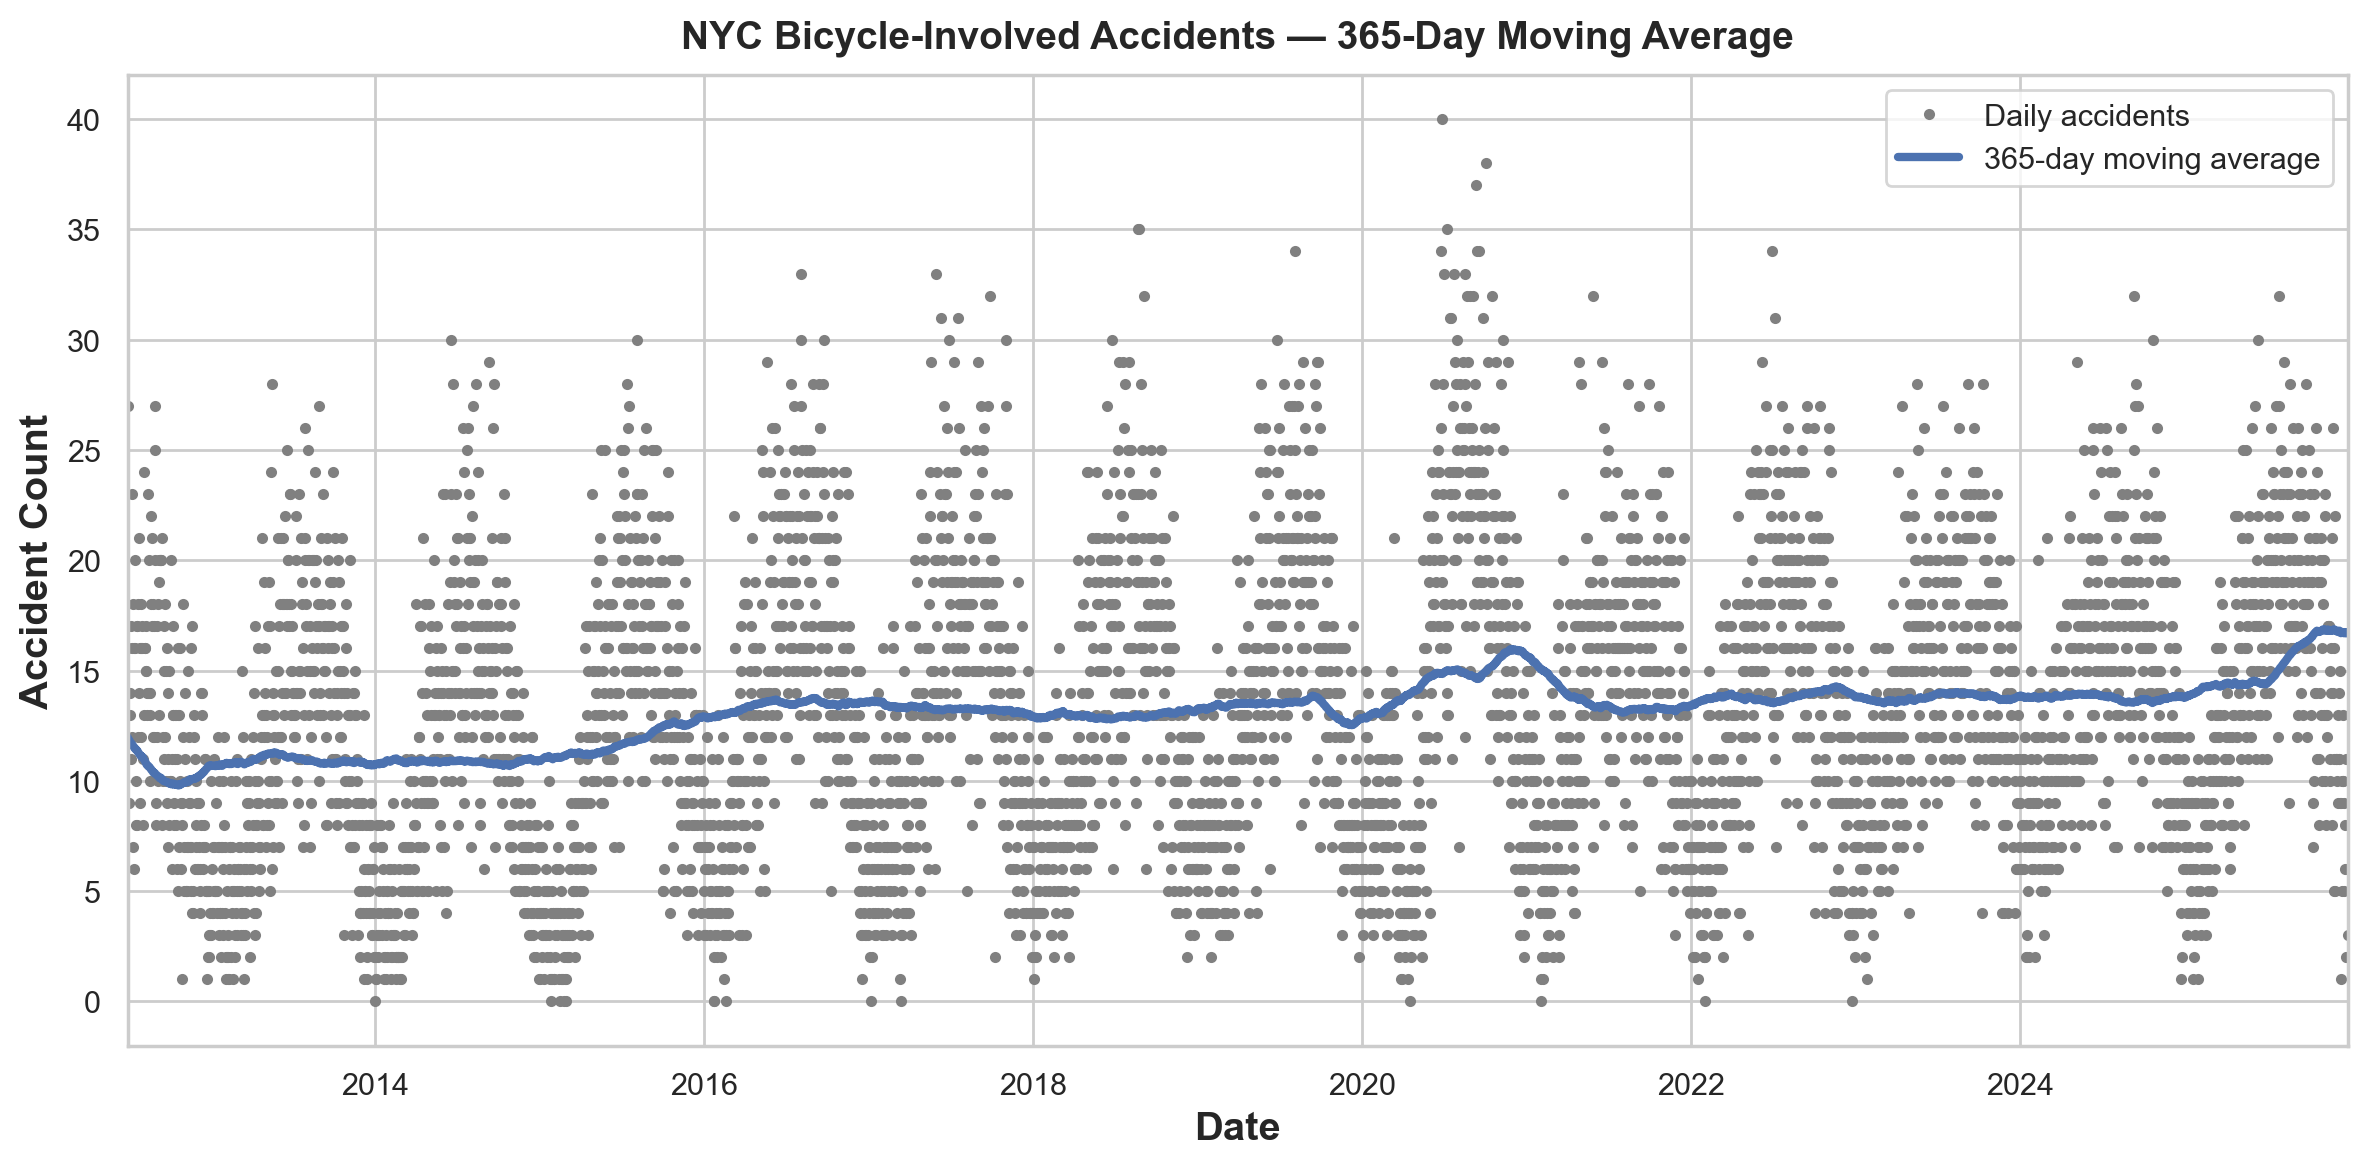

In [18]:
# 365-day centered moving average (for visualization only)
moving_average = (
    df_daily["accident_count"]
        .rolling(
            window=365,
            center=True,
            min_periods=183
        )
        .mean()
)

ax = df_daily["accident_count"].plot(
    style=".",
    color="0.5",
    figsize=(12, 6),
    label="Daily accidents",
)
moving_average.plot(
    ax=ax,
    linewidth=3,
    label="365-day moving average",
    title="NYC Bicycle-Involved Accidents — 365-Day Moving Average",
)
ax.set_ylabel("Accident Count")
ax.set_xlabel("Date")
ax.legend()
plt.show()

- seems to be roughly linear
- unusual peak during covid, maybe more (unskilled) people rode bycicles to avoid contamination risk in subways,..  (maybe add covid flag later)

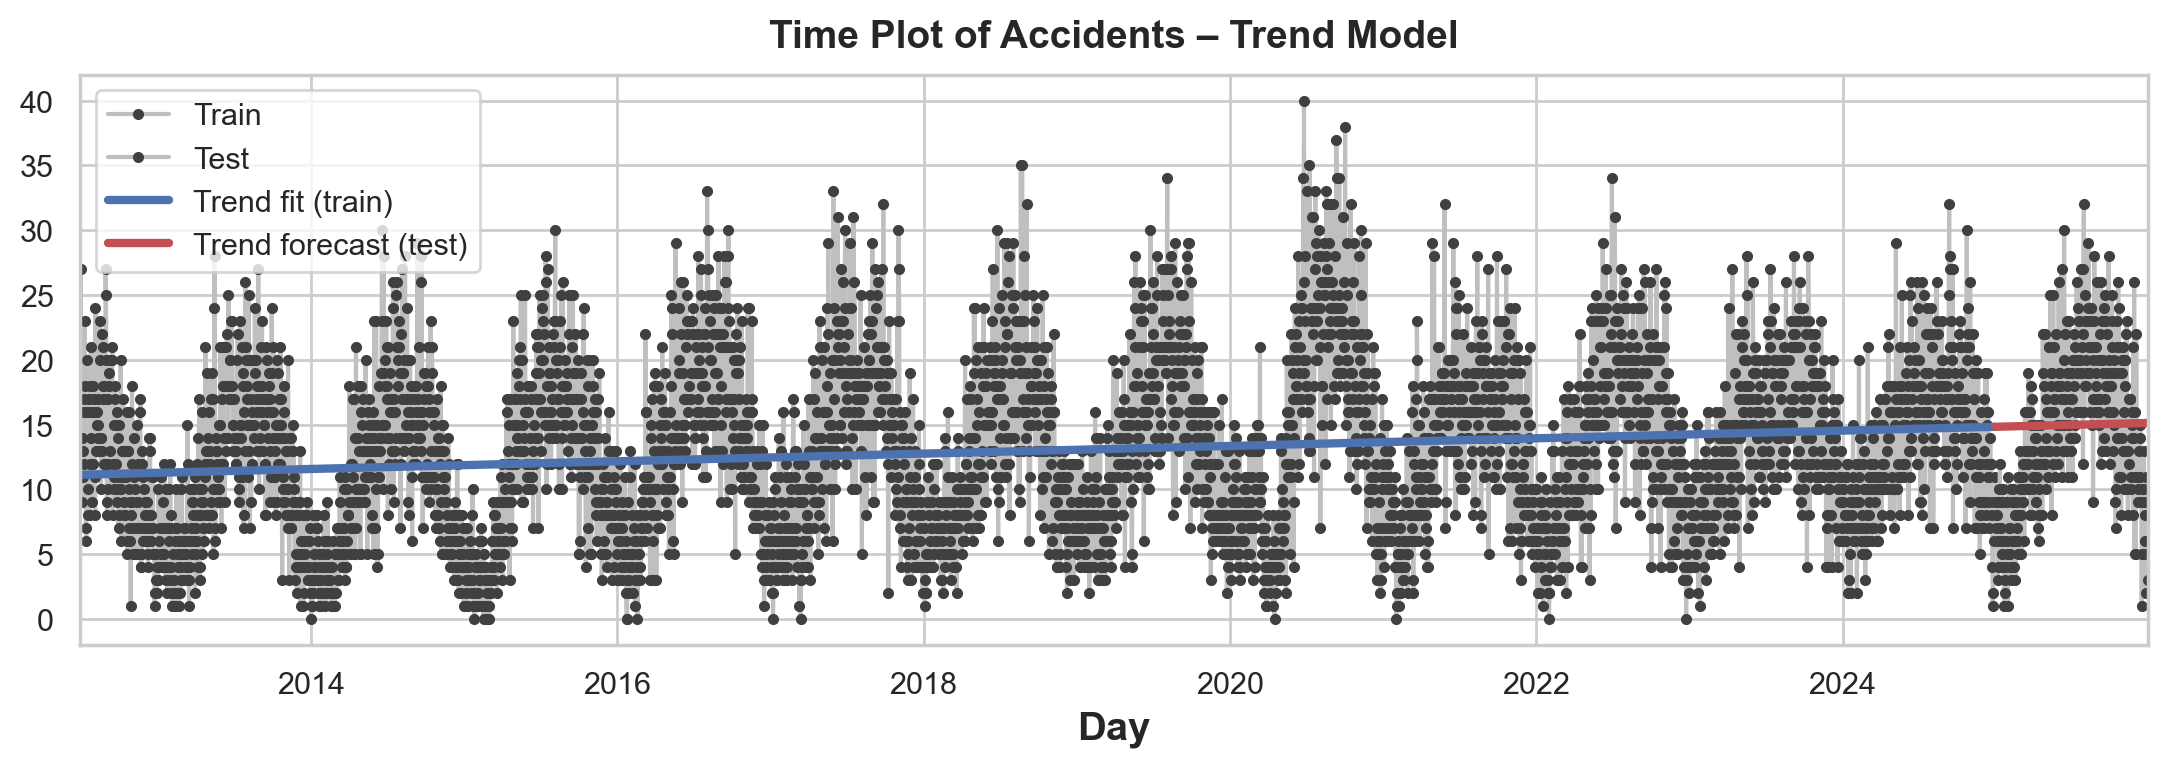

Trend model MAE (train): 5.31270882507101
Trend model MAE (test):  5.200766778816822


In [19]:
# --- Trend-only linear regression ---
X_trend = df_daily[["Time"]]
y = df_daily["accident_count"]

X_train_trend, X_test_trend, y_train_trend, y_test_trend = time_series_train_test_split(
    X_trend, y, test_horizon=365
)

trend_model = LinearRegression()
trend_model.fit(X_train_trend, y_train_trend)

y_pred_trend_train = pd.Series(
    trend_model.predict(X_train_trend),
    index=X_train_trend.index,
)
y_pred_trend_test = pd.Series(
    trend_model.predict(X_test_trend),
    index=X_test_trend.index,
)

# Plot train + test with fitted trend
ax = y_train_trend.plot(**plot_params, label="Train")
y_test_trend.plot(ax=ax, **plot_params, label="Test")
y_pred_trend_train.plot(ax=ax, linewidth=3, label="Trend fit (train)")
y_pred_trend_test.plot(ax=ax, linewidth=3, color="C3", label="Trend forecast (test)")
ax.set_title("Time Plot of Accidents – Trend Model")
ax.legend()
plt.show()

# MAE
mae_trend_train = mean_absolute_error(y_train_trend, y_pred_trend_train)
mae_trend_test = mean_absolute_error(y_test_trend, y_pred_trend_test)

print("Trend model MAE (train):", mae_trend_train)
print("Trend model MAE (test): ", mae_trend_test)

# Store trend predictions for later (full in-sample)
df_daily["trend_pred"] = trend_model.predict(X_trend)

- seems to generalize well lol (thats a joke, this model with this feature has insane bias and the average accident per day value is 13, so the error is way to high)

## B) Seasonality

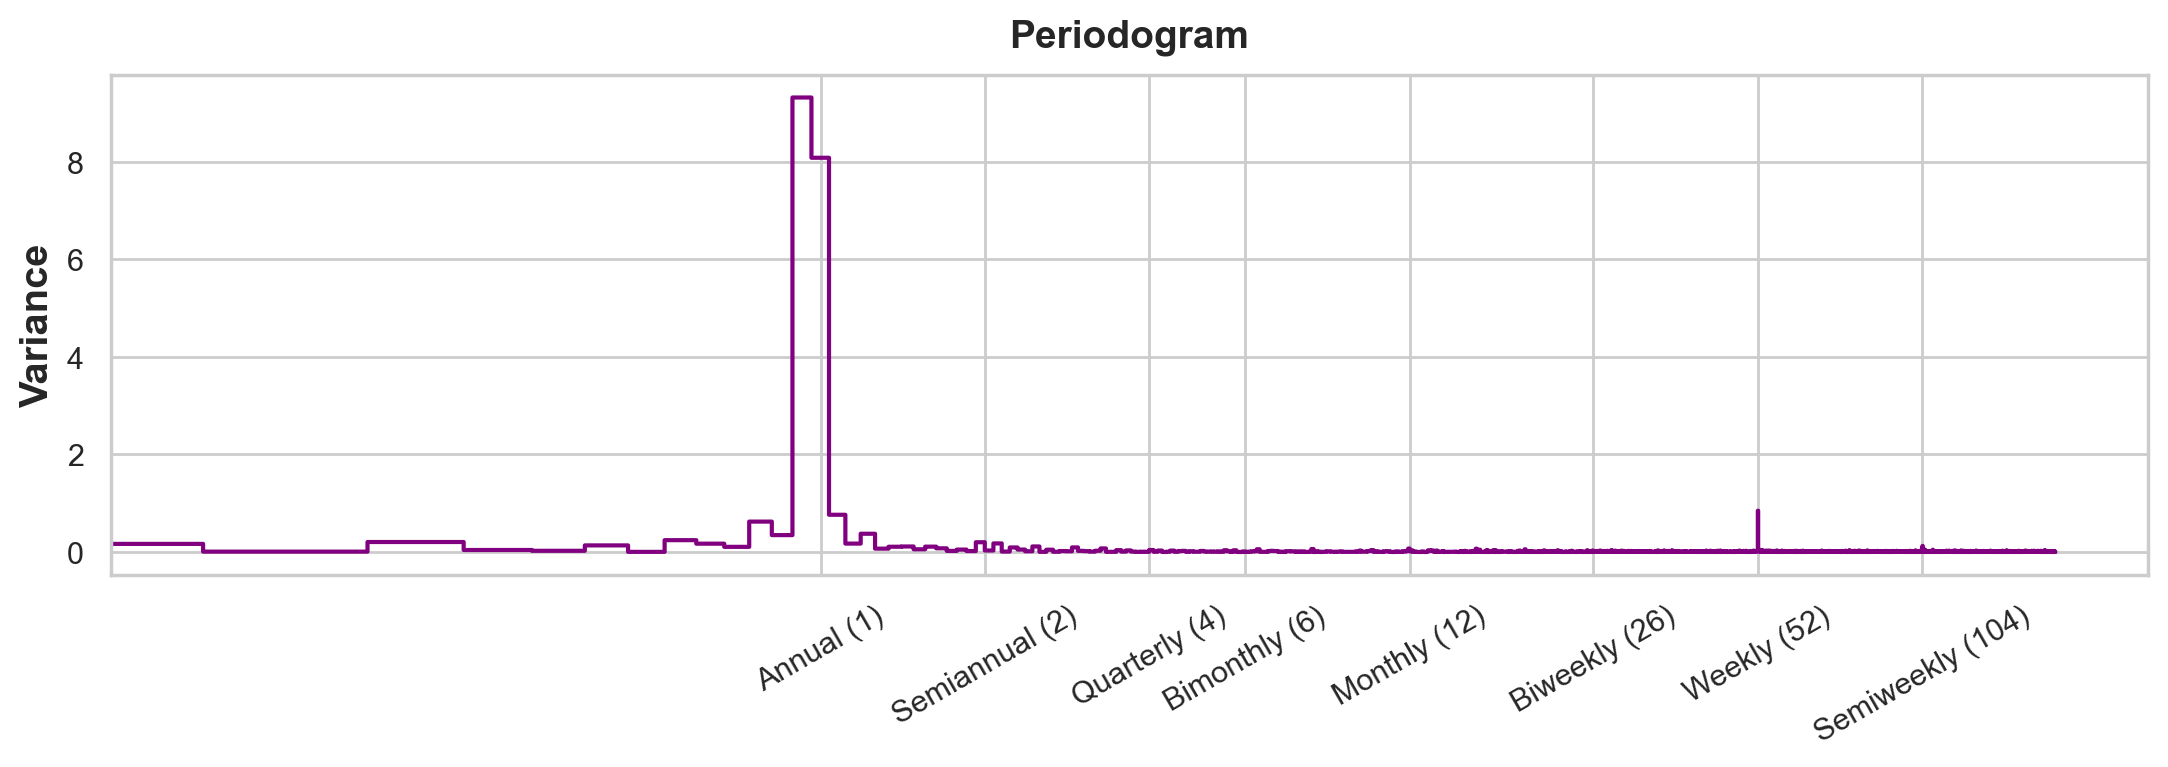

In [20]:
def plot_periodogram(
    ts: pd.Series,
    detrend: str = "linear",
    ax: Optional[Axes] = None,
) -> Axes:
    """
    Plot the periodogram of a time series.
    """
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")  # ~365 obs per year
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )

    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


# Inspect seasonality
_ = plot_periodogram(df_daily["accident_count"])
plt.show()

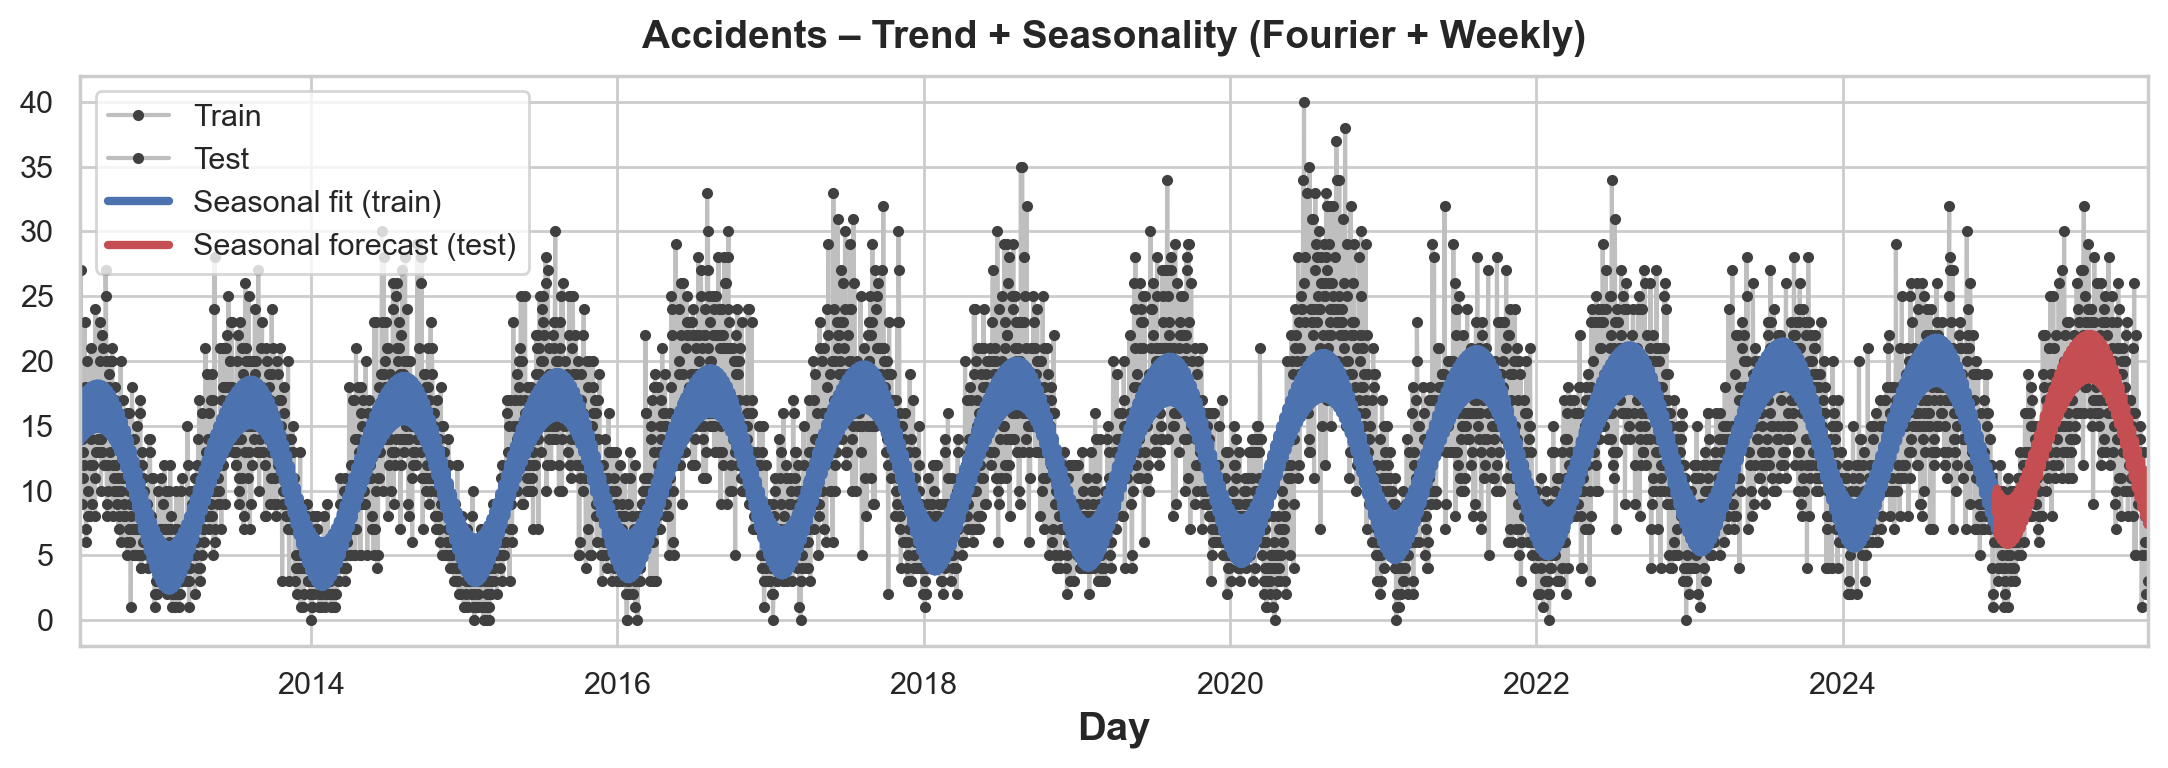

Seasonal model MAE (train): 3.537876850850799
Seasonal model MAE (test):  3.2140556765956827


In [21]:
# --- Fourier + weekly seasonality model ---
fourier = CalendarFourier(freq="YE", order=2)  # Annual + semiannual

dp = DeterministicProcess(
    index=df_daily.index,
    order=1,                     # linear trend
    seasonal=True,               # weekly seasonality (for daily PeriodIndex)
    additional_terms=[fourier],  # annual/semiannual via Fourier
    drop=True,                   # avoid collinearity
)

X_seasonal = dp.in_sample()
y = df_daily["accident_count"]

X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = time_series_train_test_split(
    X_seasonal, y, test_horizon=365
)

seasonal_model = LinearRegression()
seasonal_model.fit(X_train_seasonal, y_train_seasonal)

y_pred_seasonal_train = pd.Series(
    seasonal_model.predict(X_train_seasonal),
    index=X_train_seasonal.index,
)
y_pred_seasonal_test = pd.Series(
    seasonal_model.predict(X_test_seasonal),
    index=X_test_seasonal.index,
)

# Plot train + test vs seasonal model
ax = y_train_seasonal.plot(**plot_params, label="Train")
y_test_seasonal.plot(ax=ax, **plot_params, label="Test")
y_pred_seasonal_train.plot(ax=ax, linewidth=3, label="Seasonal fit (train)")
y_pred_seasonal_test.plot(ax=ax, linewidth=3, color="C3", label="Seasonal forecast (test)")
ax.set_title("Accidents – Trend + Seasonality (Fourier + Weekly)")
ax.legend()
plt.show()

# MAE
mae_seasonal_train = mean_absolute_error(y_train_seasonal, y_pred_seasonal_train)
mae_seasonal_test = mean_absolute_error(y_test_seasonal, y_pred_seasonal_test)

print("Seasonal model MAE (train):", mae_seasonal_train)
print("Seasonal model MAE (test): ", mae_seasonal_test)


- Linear Regression approximates the seasonality nicely with the fourier features

## C) Cyclic

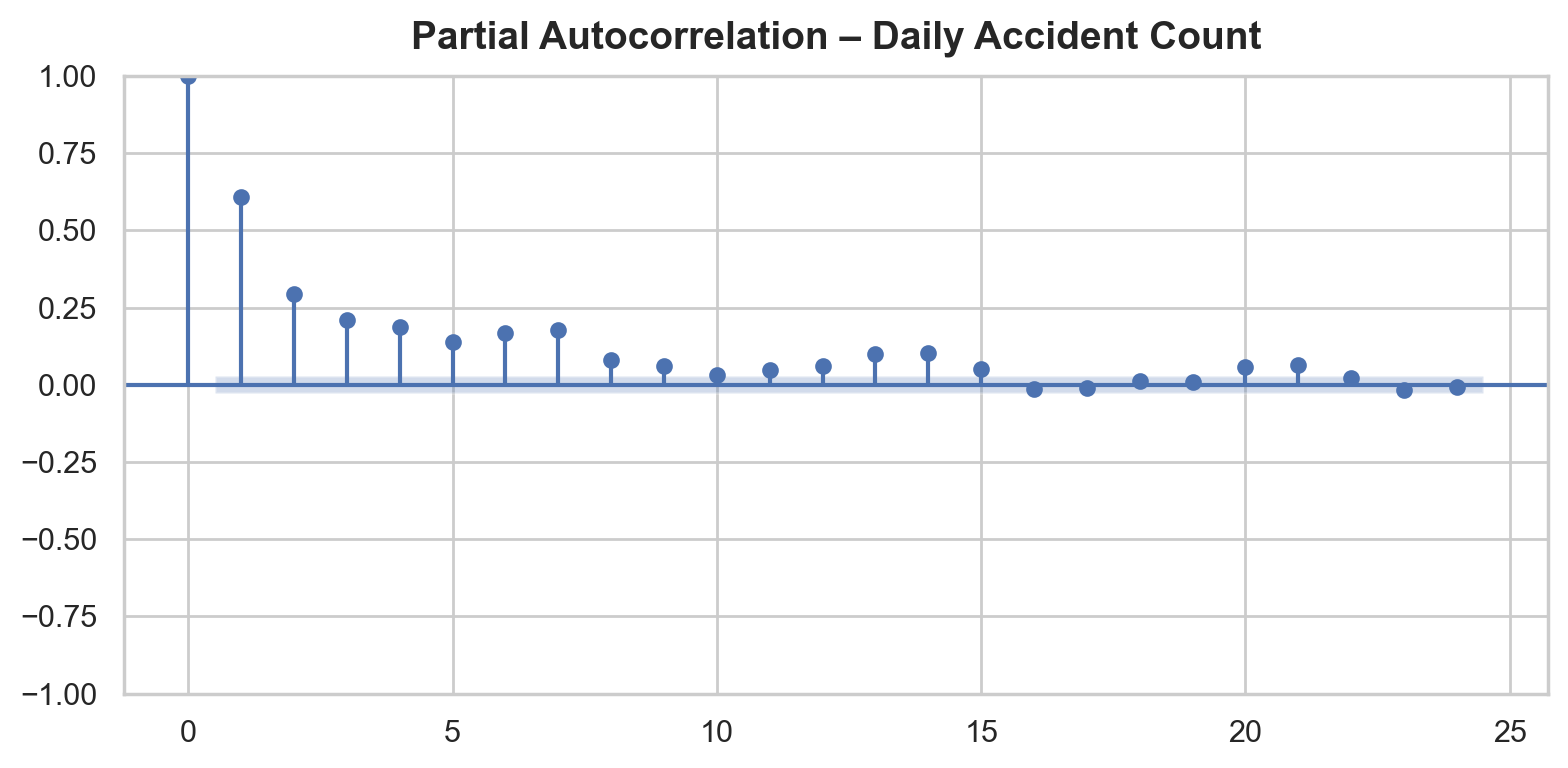

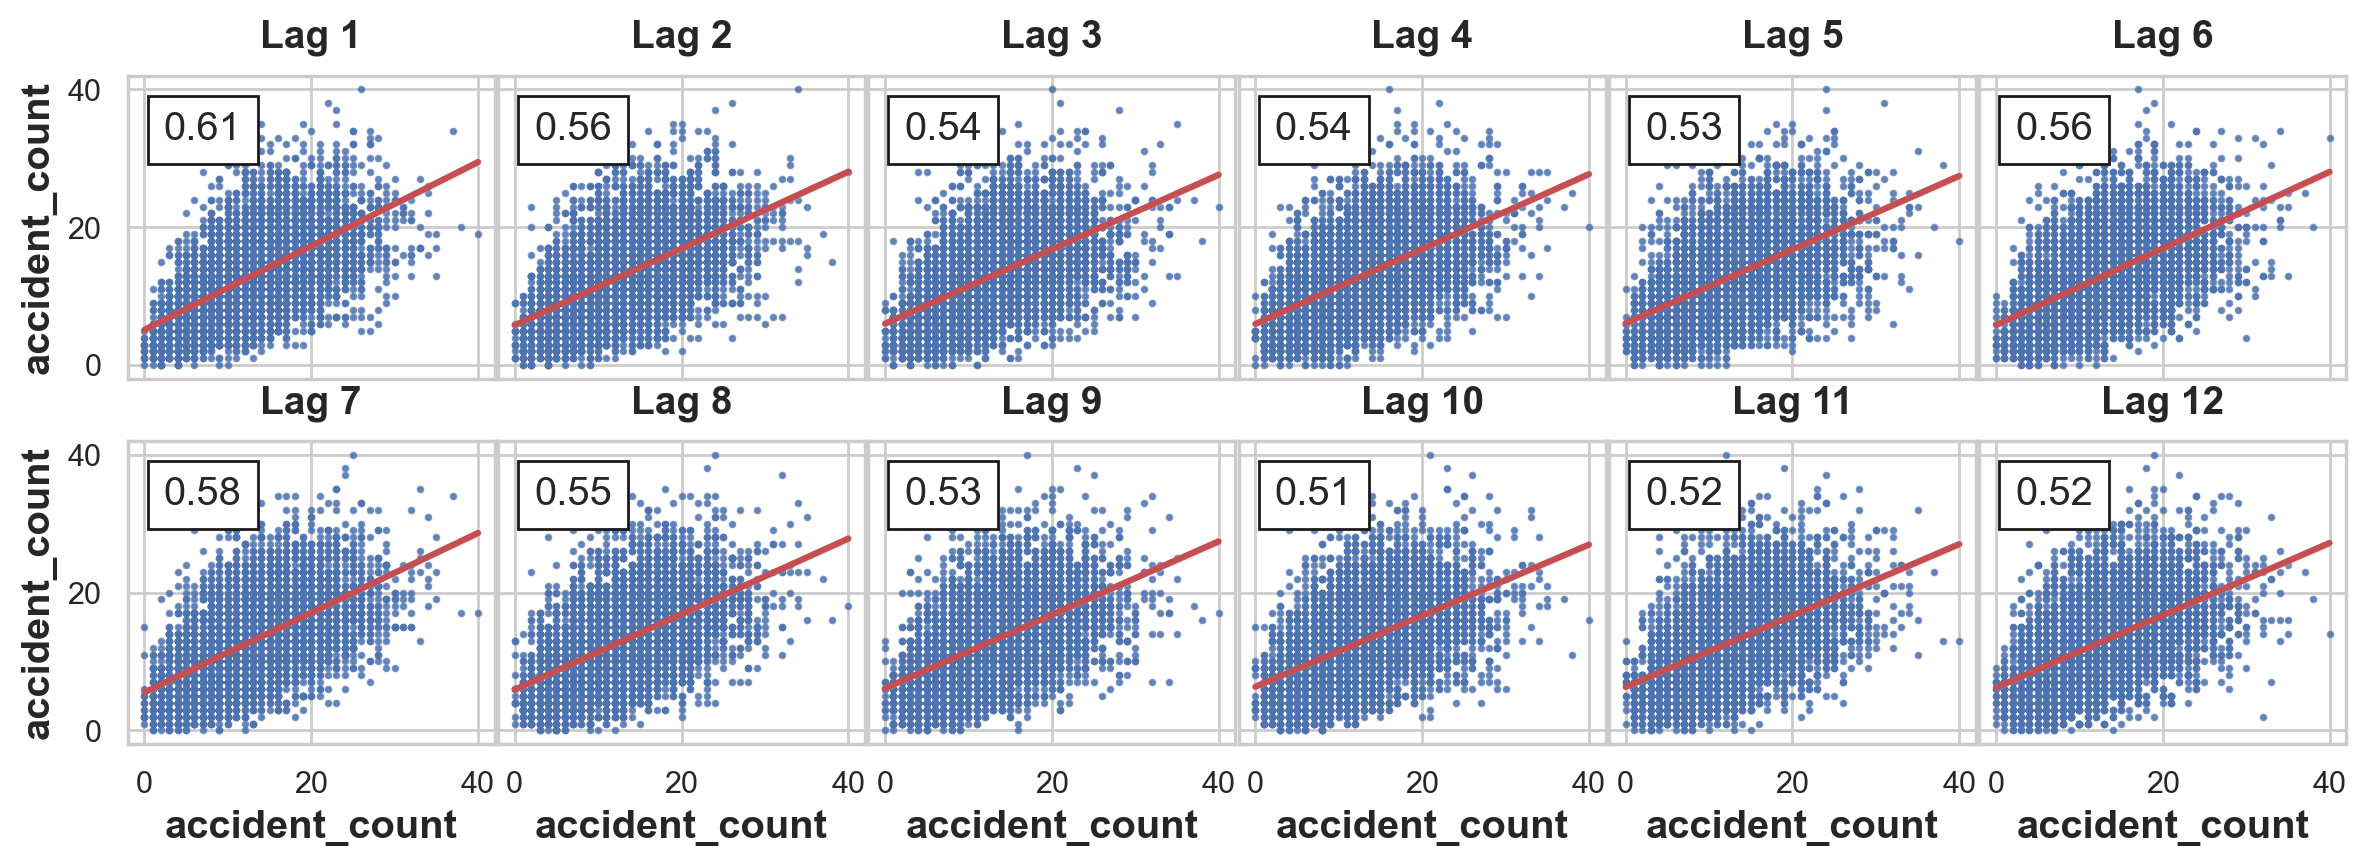

In [22]:
def lagplot(
    x: pd.Series,
    y: Optional[pd.Series] = None,
    lag: int = 1,
    standardize: bool = False,
    ax: Optional[Axes] = None,
    **kwargs: Any,
) -> Axes:
    """
    Single lag plot with optional correlation annotation.
    """
    x_ = x.shift(lag)

    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()

    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x

    corr = y_.corr(x_)

    if ax is None:
        _, ax = plt.subplots()

    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color="C3")

    ax = sns.regplot(
        x=x_,
        y=y_,
        scatter_kws=scatter_kws,
        line_kws=line_kws,
        ax=ax,
        **kwargs,
    )

    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)

    return ax


def plot_lags(
    x: pd.Series,
    y: Optional[pd.Series] = None,
    lags: int = 6,
    nrows: int = 1,
    lagplot_kwargs: Optional[Dict[str, Any]] = None,
    **kwargs: Any,
) -> Figure:
    """
    Plot multiple lag plots in a grid.
    """
    if lagplot_kwargs is None:
        lagplot_kwargs = {}

    kwargs.setdefault("nrows", nrows)
    kwargs.setdefault("ncols", math.ceil(lags / nrows))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, nrows * 2 + 0.5))

    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)

    for ax, k in zip(fig.get_axes(), range(kwargs["nrows"] * kwargs["ncols"])):
        if k + 1 <= lags:
            lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")

    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    return fig


series_accidents = df_daily["accident_count"]

# PACF
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(series_accidents, lags=24, ax=ax)
ax.set_title("Partial Autocorrelation – Daily Accident Count")
plt.show()

# Lag plots
_ = plot_lags(series_accidents, lags=12, nrows=2)
plt.show()

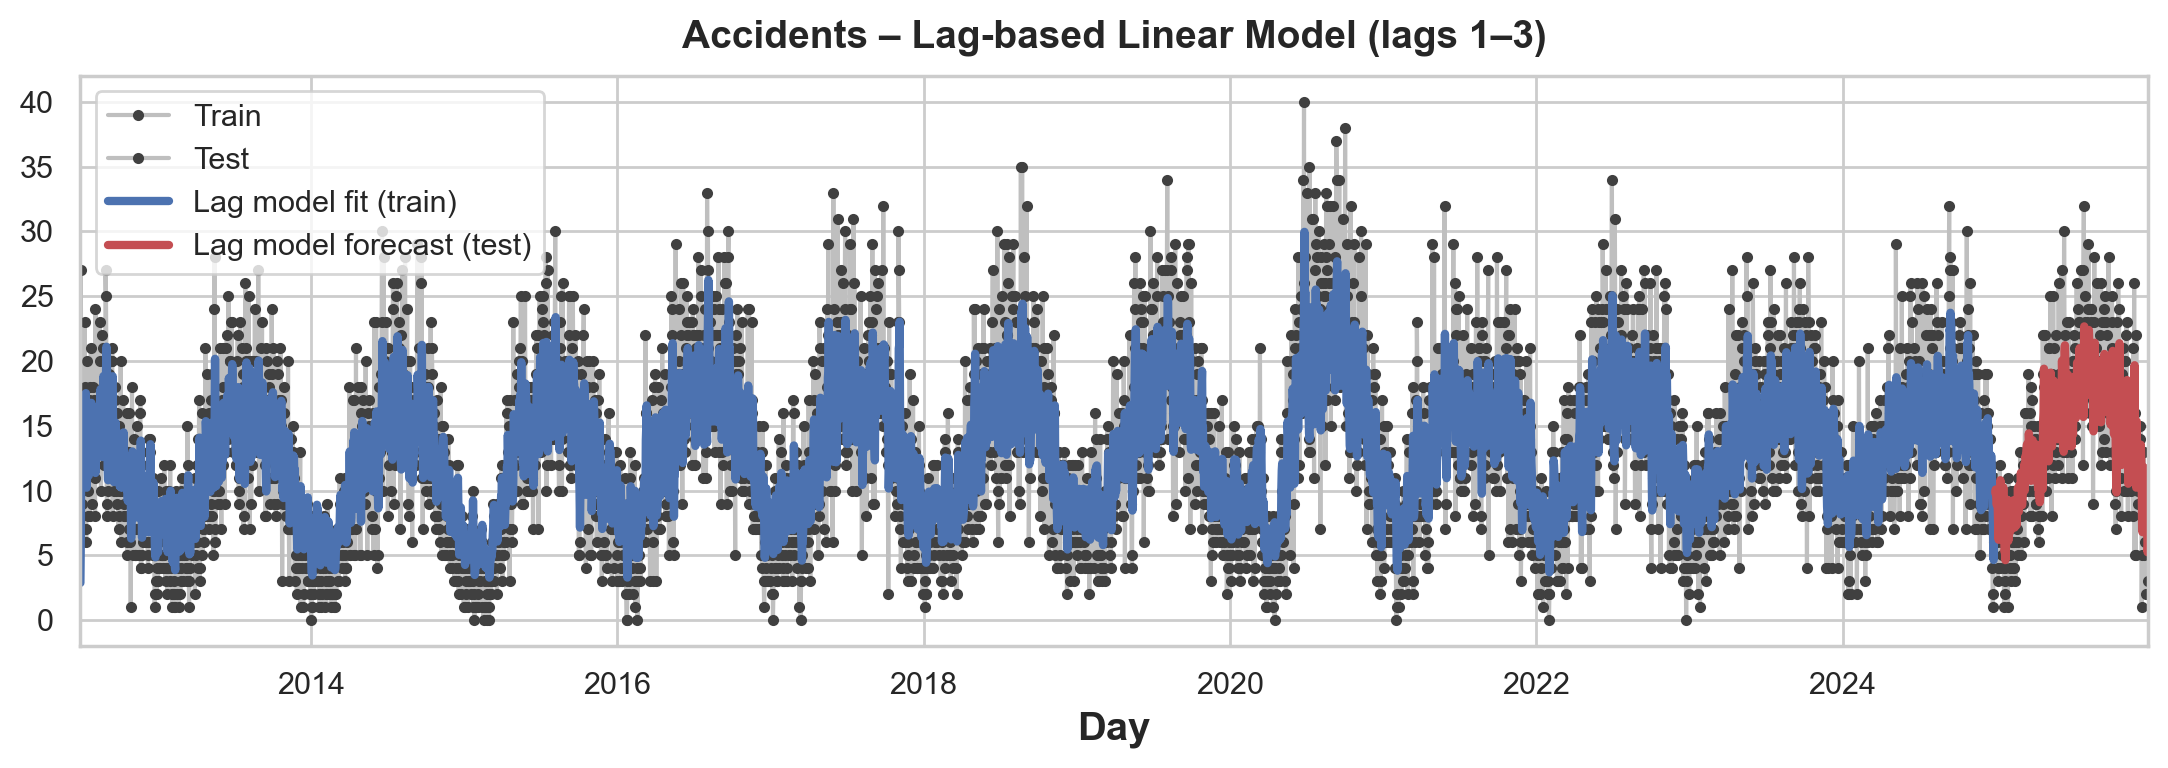

Lag model MAE (train): 3.783039910632452
Lag model MAE (test):  3.6564981349893526


In [23]:
def make_lags(ts: pd.Series, lags: int) -> pd.DataFrame:
    """
    Create DataFrame with lagged versions of a time series.
    
    Columns are named y_lag_1, y_lag_2, ..., y_lag_{lags}.
    """
    return pd.concat(
        {f"y_lag_{i}": ts.shift(i) for i in range(1, lags + 1)},
        axis=1,
    )


# Create lag features
X_lags = make_lags(df_daily["accident_count"], lags=3)

# Simple strategy: fill initial NaNs with 0.0 (other strategies possible)
X_lags = X_lags.fillna(0.0)

y = df_daily["accident_count"]

X_train_lags, X_test_lags, y_train_lags, y_test_lags = time_series_train_test_split(
    X_lags, y, test_horizon=365
)

lags_model = LinearRegression()
lags_model.fit(X_train_lags, y_train_lags)

y_pred_lags_train = pd.Series(
    lags_model.predict(X_train_lags),
    index=X_train_lags.index,
)
y_pred_lags_test = pd.Series(
    lags_model.predict(X_test_lags),
    index=X_test_lags.index,
)

# Plot train + test vs lag model
ax = y_train_lags.plot(**plot_params, label="Train")
y_test_lags.plot(ax=ax, **plot_params,  label="Test")
y_pred_lags_train.plot(ax=ax, linewidth=3, label="Lag model fit (train)")
y_pred_lags_test.plot(ax=ax, linewidth=3, color="C3", label="Lag model forecast (test)")
ax.set_title("Accidents – Lag-based Linear Model (lags 1–3)")
ax.legend()
plt.show()

# MAE
mae_lags_train = mean_absolute_error(y_train_lags, y_pred_lags_train)
mae_lags_test = mean_absolute_error(y_test_lags, y_pred_lags_test)

print("Lag model MAE (train):", mae_lags_train)
print("Lag model MAE (test): ", mae_lags_test)

- the lag features also lead to much improvement, one could also look at the lag features lat_(7*24), .....
- result is similar to the fourier one

## D) Weather

- to keep it simple I only selected Precipitation sum which is probably the most influencal weather factor regarding bycicle accidents

In [24]:
DATA_PATH_WEATHER = "../data/open-meteo-40.74N74.04W51m.csv"

df_weather = pd.read_csv(
    DATA_PATH_WEATHER
)

print("Raw shape:", df_weather.shape)
display(df_weather.head())

Raw shape: (4930, 2)


,time,precipitation_sum (mm)
0,2012-07-01,1.7
1,2012-07-02,0.0
2,2012-07-03,0.0
3,2012-07-04,3.9
4,2012-07-05,0.0


In [25]:
# Parse time column to datetime
df_weather["time"] = pd.to_datetime(df_weather["time"])

# Set a PeriodIndex with daily freq to match df_daily.index
df_weather.index = pd.PeriodIndex(df_weather["time"], freq="D")

# Clean column name
df_weather = df_weather.rename(columns={"precipitation_sum (mm)": "precipitation_sum_mm"})

# Keep only the precipitation column for merging
df_weather = df_weather[["precipitation_sum_mm"]]

# --- Rebuild deterministic (trend/seasonality) features ---
fourier = CalendarFourier(freq="YE", order=2)
dp_full = DeterministicProcess(
    index=df_daily.index,   # same daily PeriodIndex as before
    order=1,                # linear trend
    seasonal=True,          # weekly seasonality (dummies)
    additional_terms=[fourier],  # annual seasonality via Fourier terms
    drop=True,
)
X_seasonal_full = dp_full.in_sample()

# --- Lag features (for all dates) ---
X_lags_full = make_lags(df_daily["accident_count"], lags=3)
X_lags_full = X_lags_full.fillna(0.0)
# --- Combine everything: target, time-based features, lags, weather ---
df_features = (
    df_daily.join(X_seasonal_full)
            .join(X_lags_full)
            .join(df_weather)   # adds "precipitation_sum_mm"
)

df_features.head()

,accident_count,Time,trend_pred,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)",y_lag_1,y_lag_2,y_lag_3,precipitation_sum_mm
Day,,,,,,,,,,,,,,,,,,,
2012-07-01,9,0,11.137808,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.716633e-02,-0.999853,-3.432760e-02,0.999411,0.0,0.0,0.0,1.7
2012-07-02,27,1,11.138618,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.000000,-2.449294e-16,1.000000,9.0,0.0,0.0,0.0
2012-07-03,16,2,11.139429,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.716633e-02,-0.999853,3.432760e-02,0.999411,27.0,9.0,0.0,0.0
2012-07-04,9,3,11.140239,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.432760e-02,-0.999411,6.861474e-02,0.997643,16.0,27.0,9.0,3.9
2012-07-05,14,4,11.141050,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-5.147875e-02,-0.998674,1.028210e-01,0.994700,9.0,16.0,27.0,0.0


In [26]:
df_features.isna().sum()

accident_count          0
Time                    0
trend_pred              0
trend                   0
s(1,7)                  0
s(2,7)                  0
s(3,7)                  0
s(4,7)                  0
s(5,7)                  0
s(6,7)                  0
s(7,7)                  0
sin(1,freq=YE-DEC)      0
cos(1,freq=YE-DEC)      0
sin(2,freq=YE-DEC)      0
cos(2,freq=YE-DEC)      0
y_lag_1                 0
y_lag_2                 0
y_lag_3                 0
precipitation_sum_mm    0
dtype: int64

# Time series modelling

- create accident per day prediction model

Candidates:
- linear Regression & Ridge Regression because they are feature transforming alogrithm and because of that can  extrapolate target values beyond the training set (which is important since we have an increasing trend in the data)
- XGBoost and Randomforest are the best perfoming algorithms for tabular data but they are target transformers which will always be bound within the range of the training set (but most of the structure is seasonal/cyclic)

In [27]:
#prepare training/test data
df_model = df_features.copy()

target_col = "accident_count"
feature_cols = [col for col in df_model.columns if col != target_col]

X = df_model[feature_cols]
y = df_model[target_col]

# Hold out the last 365 days for testing
n_test = 365
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

print(X_train.shape, X_test.shape)


(4565, 18) (365, 18)


In [28]:
# Linear Regression
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
lr.fit(X_train, y_train)

# Ridge Regression + small alpha search using time-series CV
tscv = TimeSeriesSplit(n_splits=5)

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_params = {"model__alpha": [0.1, 1.0, 10.0, 100.0]}

ridge_search = GridSearchCV(
    ridge,
    ridge_params,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

ridge_search.fit(X_train, y_train)
ridge_best = ridge_search.best_estimator_

# Random Forest
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

models: Dict[str, Any] = {
    "LinearRegression": lr,
    "Ridge": ridge_best,
    "RandomForest": rf,
    "XGBoost": xgb,
}

In [29]:
#evaluate models

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    results.append({
        "model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
    })

results_df = pd.DataFrame(results).set_index("model").sort_values("MAE")
results_df

,MAE,RMSE,R2
model,,,
LinearRegression,3.201490,16.373728,0.577514
Ridge,3.203705,16.407493,0.576643
XGBoost,3.319405,18.404350,0.525119
RandomForest,3.350130,18.031697,0.534734


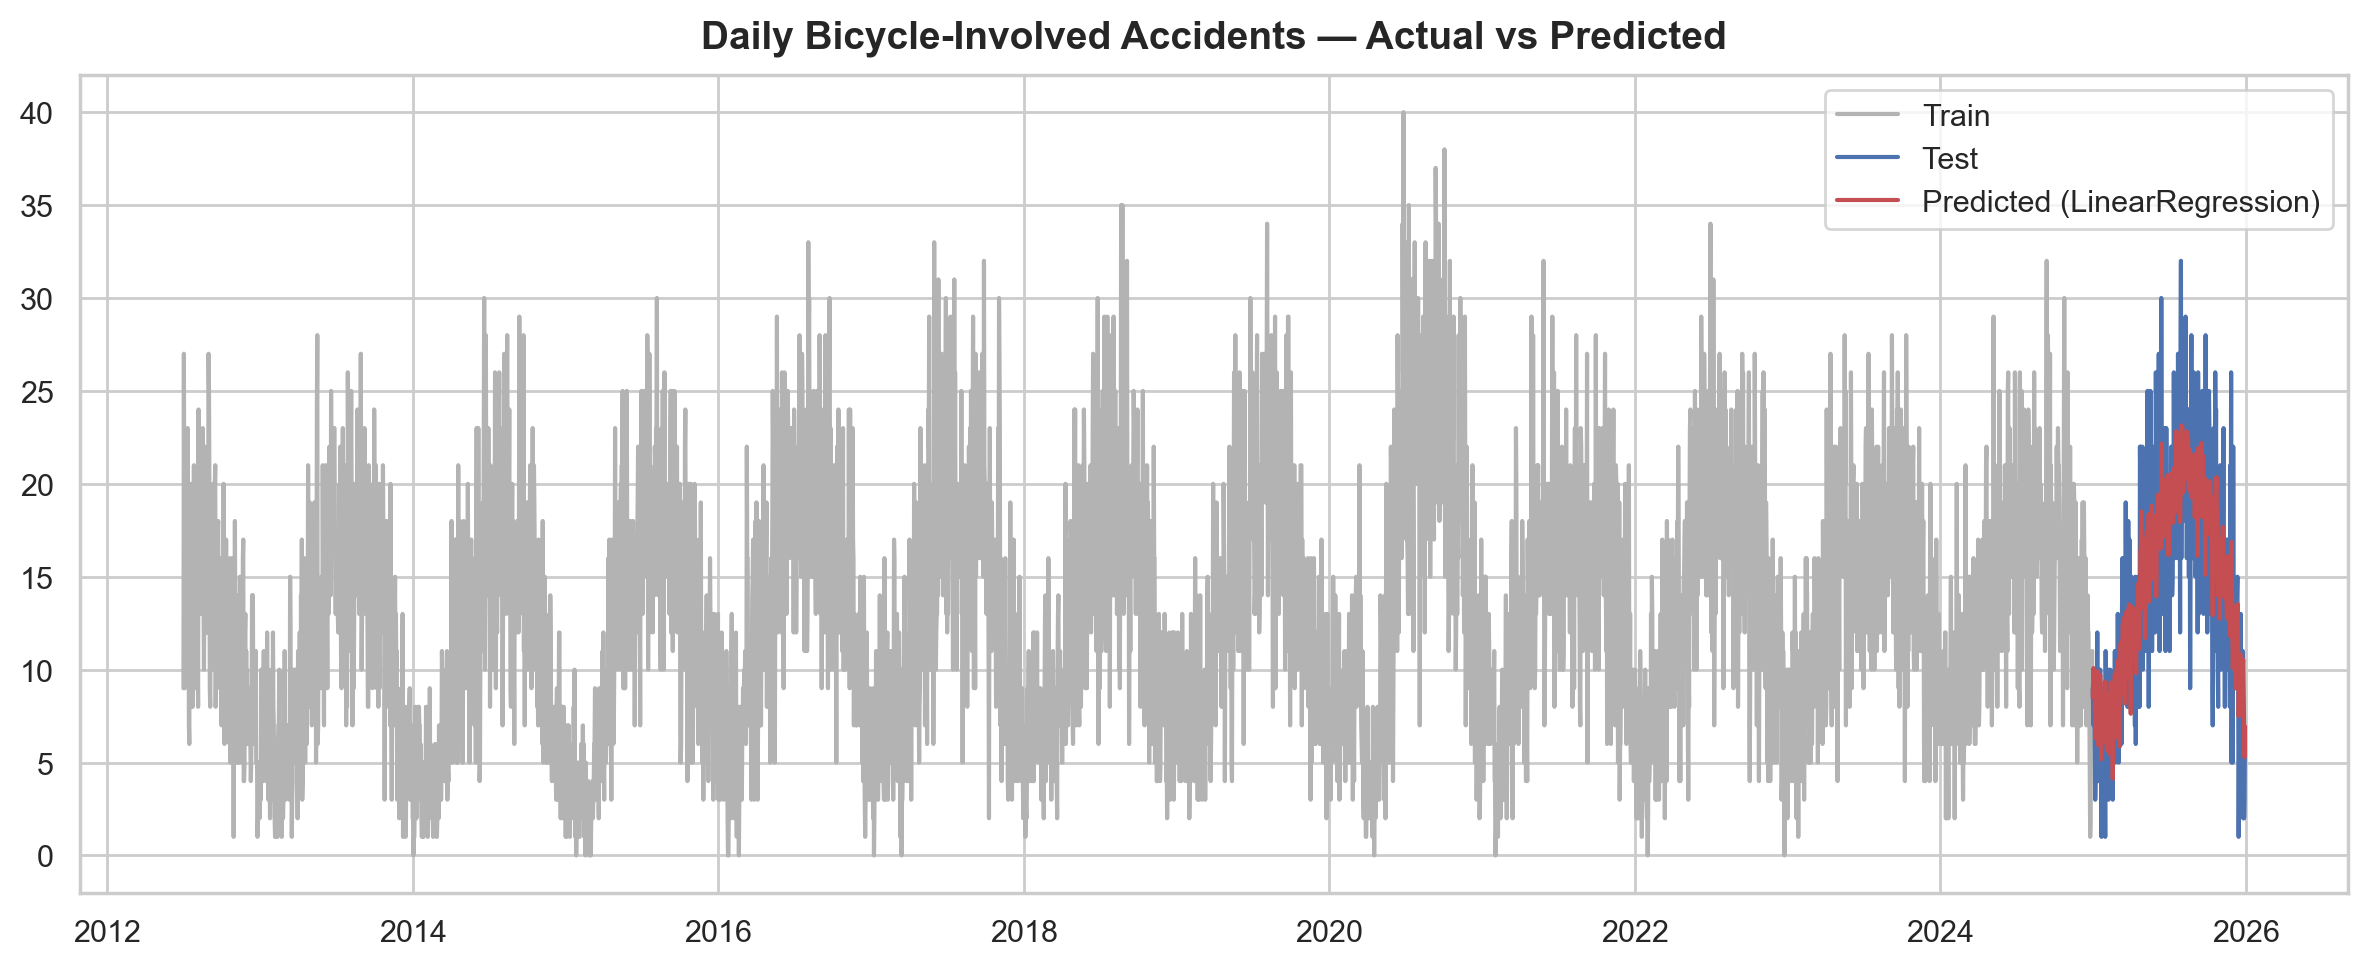

In [30]:
#visualize best model

best_model_name = results_df.index[0]
best_model = models[best_model_name]

y_pred = pd.Series(best_model.predict(X_test), index=y_test.index)

plt.figure(figsize=(12,5))
plt.plot(y_train.index.to_timestamp(), y_train, label="Train", color="0.7")
plt.plot(y_test.index.to_timestamp(), y_test, label="Test ", color="C0")
plt.plot(y_test.index.to_timestamp(), y_pred, label=f"Predicted ({best_model_name})", color="C3")
plt.title("Daily Bicycle-Involved Accidents — Actual vs Predicted")
plt.legend()
plt.show()

- Linear and ridge regression achieve the best results, explaining ~58% of the variance in daily crash counts with an average forecasting error of ~3.2 crashes per day (vs. a daily mean of 16). Tree-based models underperform slightly because they interpolate within the training range and do not extrapolate the long-term trend as effectively as linear models.

- the results are ok considering that accidents per day is not a deterministic target but has a lot of noise in it

- Outlook: Maybe a Hybrid model (1. linear regression, 2. XGBoost on residuals) would perform better combining the strengths of regression with the strenghs of trees